# Исследование данных сервиса аренды самокатов GoFast

**Цель исследования**

Необходимо провести анализ данных и проверить некоторые гипотезы, чтобы помочь бизнесу вырасти. 

**Описание данных**

Мы будем работать с данными из следующих файлов:
- /datasets/users_go.csv,
где:
  - user_id - уникальный идентификатор пользователя;
  - name - имя пользователя;
  - age - возраст;
  - city - город;
  - subscription_type -  тип подписки;
  
    free:
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
    
    ultra:
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно);
    
- /datasets/rides_go.csv,
где:
  - user_id - уникальный идентификатор пользователя;
  - distance - расстояние, которое пользователь проехал в текущей сессии (в метрах);
  - duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
  - date - дата совершения поездки;
  
- /datasets/subscriptions_go.csv,
где:
  - subscription_type - тип подписки;
  - minute_price - стоимость одной минуты поездки по данной подписке;
  - start_ride_price - стоимость начала поездки;
  - subscription_fee - стоимость ежемесячного платежа.
 
О качестве данных ничего не известно. Поэтому перед исследованием данных понадобится их обзор.

**Ход исследования**

Изучим общую информацию о датасетах. Что можно сказать о каждом столбце? Значения какого типа они хранят? 

Проверим данные на ошибки, и оценим их влияние на исследование, затем, на этапе предобработки, изучим возможность исправить самые критичные ошибки в данных.

Далее проведем необходимые вычисления, на основании которых проанализируем данные и, таким образом, исследование пройдёт в 9 этапов:

- [Загрузка и базовый анализ данных.](#1)
- [Предобработка данных.](#2)
- [Исследовательский анализ данных.](#3)
- [Объединение данных.](#4)
- [Подсчет выручки.](#5)
- [Дополнительный исследовательский анализ.](#6)
- [Проверка гипотез.](#7)
- [Распределения](#8)
- [Общий вывод.](#9)

<a id="1"></a>

### Загрузка и обзор данных

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from scipy import stats as st
from scipy.stats import binom, norm 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Чтение файлов
path1 = '/Users/marina/CSV_files/users_go.csv'
path2 = '/Users/marina/CSV_files/rides_go.csv'
path3 = '/Users/marina/CSV_files/subscriptions_go.csv'

if os.path.exists(path1):
    users = pd.read_csv(path1)
    
if os.path.exists(path2):
    rides = pd.read_csv(path2)    

if os.path.exists(path3):
    subscriptions = pd.read_csv(path3)    

else:
    print('Something is wrong')

In [3]:
# Выводим основную информацию по датасету users
display(users.head())
print()
users.info()
print()
# Выводим описание количественных данных в столбце age
display(users['age'].describe())
print()
print('Самый часто встречающийся возраст:', users["age"].mode())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB



count    1565.000000
mean       24.922045
std         4.553496
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


Самый часто встречающийся возраст: 0    25
Name: age, dtype: int64


В датасете users 5 столбцов, 1565 строк.

Согласно документации к данным:
1. user_id — уникальный идентификатор пользователя;
2. name - имя пользователя;
3. age - возраст;
4. city - город;
5. subscription_type - тип подписки.

С типами данных в столбцах все в порядке. 

Минимальный возраст пользователя приложения - 12 лет, максимальный 43 года, больше всего пользователей в возрасте 25 лет.

In [4]:
# Выводим основную информацию по датасету rides
display(rides.head())
print()
rides.info()
print()
# Выводим описание количественных данных в столбцах distance и duration
display(rides[['distance', 'duration']].describe())
print()
print('Самое часто встречающееся время поездки:', rides["duration"].mode())

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB



,distance,duration
count,18068.000000,18068.000000
mean,3070.659976,17.805011
std,1116.831209,6.091051
min,0.855683,0.500000
25%,2543.226360,13.597563
50%,3133.609994,17.678395
75%,3776.222735,21.724800
max,7211.007745,40.823963



Самое часто встречающееся время поездки: 0    0.5
Name: duration, dtype: float64


В датасете rides 4 столбца, 18068 строк.

Согласно документации к данным:
1. user_id — уникальный идентификатор пользователя;
2. distance - расстояние, которое пользователь проехал в текущей сессии (в метрах);
3. duration - продолжительность сессии (в минутах);
4. date - дата соверщения поездки.

В стобце date необходимо поменять тип данных на datetime. Чаще всего в датасете встречаются минимальные значения по времени поездки (0.5 минут). Минимальное расстояние - 0.855683 метров. Надо обратить на это внимание, странные значения.

In [5]:
# Выводим основную информацию по датасету subscriptions
display(subscriptions.head())
print()
subscriptions.info()
print()
# Выводим описание количественных данных в столбцах distance и duration
display(subscriptions[['minute_price', 'start_ride_price', 'subscription_fee']].describe())

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes



,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000


В датасете subscriptions 4 столбца, 2 строки.

Согласно документации к данным:
1. subscription_type — тип подписки;
2. minute_price - стоимость 1 минуты поездки по подписке;
3. start_ride_price - стоимость начала поездки;
4. subscription_fee - стоимость ежемесячного платежа.

С типами данных в толбцах все в порядке.

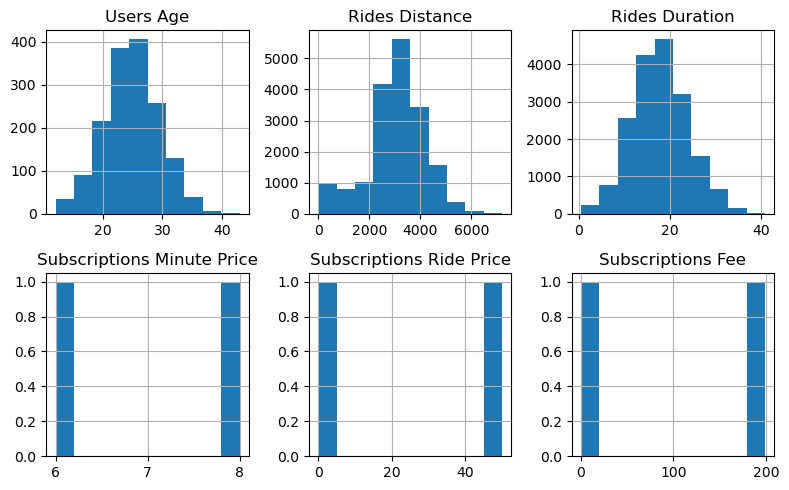

In [6]:
# Построим гистограммы для количественных столбцов наших датасетов 
users['age'].hist(figsize=(8, 5), ax=plt.subplot(2,3,1))
plt.title('Users Age')

rides['distance'].hist(figsize=(8, 5), ax=plt.subplot(2,3,2))
plt.title('Rides Distance')

rides['duration'].hist(figsize=(8, 5), ax=plt.subplot(2,3,3))
plt.title('Rides Duration')

subscriptions['minute_price'].hist(figsize=(8, 5), ax=plt.subplot(2,3,4))
plt.title('Subscriptions Minute Price')

subscriptions['start_ride_price'].hist(figsize=(8, 5), ax=plt.subplot(2,3,5))
plt.title('Subscriptions Ride Price')

subscriptions['subscription_fee'].hist(figsize=(8, 5), ax=plt.subplot(2,3,6))
plt.title('Subscriptions Fee')

plt.tight_layout()
plt.show()

На гистограммах мы видим, что основная масса пользователей лежит в интервале от 20 до 30 лет. Наибольшие значения по расстоянию поездки лежат в интервале примерно 2100-4200 м, а время поездки в примерном интервале от 8 до 28 мин.

**Выводы:**

На данном этапе мы:
- Прочитали файлы с данными;
- Вывели и изучили общую информацию о них;

Впереди предобработка данных.

<a id="2"></a>

### Предобработка данных

#### Преобразуем типы данных, где необходимо

In [7]:
rides['date'] = pd.to_datetime(rides['date'])

#### Проверим пропуски в датасетах

In [8]:
# Создадим копии датасетов до преобразований
temp = users.copy() 
len(temp)

1565

In [9]:
temp1 = rides.copy() 
len(temp1)

18068

In [10]:
temp2 = subscriptions.copy() 
len(temp2)

2

In [11]:
# Выведем количество пропущенных значений для датасета users и отсортируем по возрастанию.
users.isna().sum().sort_values()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [12]:
# Выведем количество пропущенных значений для датасета rides и отсортируем по возрастанию.
rides.isna().sum().sort_values()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [13]:
# Выведем количество пропущенных значений для датасета subscriptions и отсортируем по возрастанию.
subscriptions.isna().sum().sort_values()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков данных в датасетах нет.

#### Проверим дубликаты в датасетах

In [14]:
# Напишем функцию для проверки данных на наличие явных дубликатов
def find_explicit_duplicates(dataset):
    
    # Находим явные дубликаты
    explicit_duplicates_cnt = display(f'Количество явных дубликатов: {dataset.duplicated().sum()}')
    
    explicit_duplicates = None
    explicit_duplicates_cnt = 0
    
    if dataset.duplicated().sum() > 0:
        explicit_duplicates = display(dataset[dataset.duplicated(keep=False)])
    
    else:
        display('Явные дубликаты не найдены')
    
    return explicit_duplicates_cnt, explicit_duplicates

In [15]:
# Проверим явные дубликаты в датасете users
dataset = users
find_explicit_duplicates(dataset)

'Количество явных дубликатов: 31'

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
46,47,Юрий,28,Тюмень,ultra
71,72,Никита,25,Москва,ultra
107,108,Влада,29,Тюмень,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


(0, None)

Найден 31 дубликат. Удалим эти строки.

In [16]:
users = users.drop_duplicates()

In [17]:
# Проверим явные дубликаты в датасете rides
dataset = rides
find_explicit_duplicates(dataset)

'Количество явных дубликатов: 0'

'Явные дубликаты не найдены'

(0, None)

In [18]:
# Проверим явные дубликаты в датасете subscriptions
dataset = subscriptions
find_explicit_duplicates(dataset)

'Количество явных дубликатов: 0'

'Явные дубликаты не найдены'

(0, None)

В датасетах rides и subscriptions явные дубликаты не найдены

In [19]:
# Напишем функцию для проверки данных на наличие неявных дубликатов
def find_implicit_duplicates(dataset, columns_to_compare):
    
    # Находим неявные дубликаты
    implicit_duplicates = dataset[dataset.duplicated(subset=columns_to_compare, keep=False)]
    if implicit_duplicates.empty:
        display('Неявных дубликатов нет.')
  
    return implicit_duplicates

In [20]:
dataset = users
columns_to_compare = ['name', 'age', 'city']
find_implicit_duplicates(dataset, columns_to_compare)

,user_id,name,age,city,subscription_type
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra
19,20,Игорь,23,Омск,ultra
...,...,...,...,...,...
1495,1496,Яна,19,Москва,free
1509,1510,Эмиль,25,Краснодар,free
1511,1512,Мария,18,Омск,free
1517,1518,Михаил,23,Сочи,free


В датасете users найдено 105 строк с неявными дубликатами. Исходя из наших данных, скорее всего это совпадение имен, так как в одном городе может быть много людей одного возраста с одинаковыми именами, и, в данном случае, доказать, что это именно дубликаты, возможности нет. Оставляем как есть.

In [21]:
dataset = rides
columns_to_compare = ['distance', 'duration', 'date']
find_implicit_duplicates(dataset, columns_to_compare)

'Неявных дубликатов нет.'

,user_id,distance,duration,date


В датасете rides неявные дубликаты не найдены. Датасет subscriptions проверять на неявные дубликаты смысла нет.

#### Проверим уникальные значения в датасетах

In [22]:
# Напишем функцию, которая будет выводить описание данных в столбце, уникальные значения и их количество
def unique_describe(dataset):
    return  display(dataset.describe(), len(dataset.unique())), print(sorted(dataset.unique()))                    

Проверим уникальные значения в столбцах  датасета users

In [23]:
dataset = users['name']
unique_describe(dataset)

count     1534
unique     194
top       Анна
freq        22
Name: name, dtype: object

194

['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра', 'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина', 'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий', 'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина', 'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём', 'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия', 'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника', 'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад', 'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод', 'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей', 'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила', 'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий', 'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена', 'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар', 'Злата', 'Иван', 'Игнат', 'Игорь', 'Ильдар', 'Илья', 'Инна', 'Ирина', 'Камилла', 'Карина', 'Каролина', 'Кира', 'К

(None, None)

Встречаются некоторые повторы имен, например, Наталия и Наталья, София и Софья, имя одно, но по дукументам может быть записано с таким различиями, а вот имя Наташа явно неполное, куда его отнести к Наталье или Наталии - непонятно. Ничего менять не будем, в данном исследовании этот факт вряд ли на что-то повлияет, так же как и то, что любительниц покататься на самокатах чаще всего зовут Мария.

In [24]:
dataset = users['age']
unique_describe(dataset)

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

29

[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43]


(None, None)

В датасете представлены люди от 12 до 39 лет включительно и 43летние.

In [25]:
dataset = users['city']
unique_describe(dataset)

count          1534
unique            8
top       Пятигорск
freq            219
Name: city, dtype: object

8

['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск', 'Ростов-на-Дону', 'Сочи', 'Тюмень']


(None, None)

В датасете представлены данные по 8 городам, чаще всего самокаты арендуют в Пятигорске.

In [26]:
dataset = users['subscription_type']
unique_describe(dataset)

count     1534
unique       2
top       free
freq       835
Name: subscription_type, dtype: object

2

['free', 'ultra']


(None, None)

В данном столбце обошлось без сюрпризов, подписка либо бесплатная, либо платная.

Уникальные значения в столбцах  датасета rides проверять смысла пока нет, там будет много разных значений по расстроянию, длительности поездки и дате, датасет subscriptions состоит всего из двух строк, уникальные значения мы видим и без проверки.

In [27]:
# Сверяем наши данные по количеству строк по окончанию обработки данных в датасетах
a, b = len(temp), len(users)
print(len(temp), len(users), round((a - b) / a * 100, 2))

1565 1534 1.98


In [28]:
a, b = len(temp1), len(rides)
print(len(temp1), len(rides), round((a - b) / a * 100, 2))

18068 18068 0.0


In [29]:
a, b = len(temp2), len(subscriptions)
print(len(temp2), len(subscriptions), round((a - b) / a * 100, 2))

2 2 0.0


#### Добавим новые столбцы 

In [30]:
# Для начала определим, за какой период нам даны данные в датасете, найдем минимальную и максимальную даты
display(f'Минимальная дата поездки: {rides["date"].min()}')
display(f'Максимальная дата поездки: {rides["date"].max()}')

'Минимальная дата поездки: 2021-01-01 00:00:00'

'Максимальная дата поездки: 2021-12-30 00:00:00'

Данные в датасете за один год - 2021, значит месяц из даты мы можем выделить методом dt.month

In [31]:
# Добавим в rides столбец  month
rides['month'] = rides['date'].dt.month

In [32]:
# Добавим  в rides столбец с сезоном на дату поездки
def categorize_season(month):
    try:
        if month in [12,1,2]:
            return 'зима'
        elif month in [3,4,5]:
            return 'весна'
        elif month in [6,7,8]:
            return 'лето'
        elif month in [9,10,11]:
            return 'осень'
    except:
        pass
    
rides['season'] = rides['month'].apply(categorize_season)

**Выводы:**

На данном этапе мы:
- преобразовали тип данных в столбце date датасета rides на datetime;
- проверили данные во всех датасетах на пропуски, они не обнаружены;
- проверили данные на явные дубликаты, в датасете users найдена 31 строка с явными дубликатами, мы их удалили;
- изучили уникальные значения в датасете users, все данные оставили без изменений;
- выяснили, что период анализа у нас с 21-01-01 по 21-12-30;
- добавили новые столбцы  month и season в датасет rides.

<a id="3"></a>

### Исследовательский анализ данных

In [33]:
# Проверим, в каких городах наиболее часто люди пользовались сервисом проката самокатов
city_frequency = users.groupby(['city']).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).\
                       reset_index()
city_frequency.columns = ['city', 'city_cnt']
city_frequency['%_from_total'] = round(((city_frequency['city_cnt'] / city_frequency['city_cnt'].sum()) * 100),1)
city_frequency

,city,city_cnt,%_from_total
0,Пятигорск,219,14.3
1,Екатеринбург,204,13.3
2,Ростов-на-Дону,198,12.9
3,Краснодар,193,12.6
4,Сочи,189,12.3
5,Омск,183,11.9
6,Тюмень,180,11.7
7,Москва,168,11.0


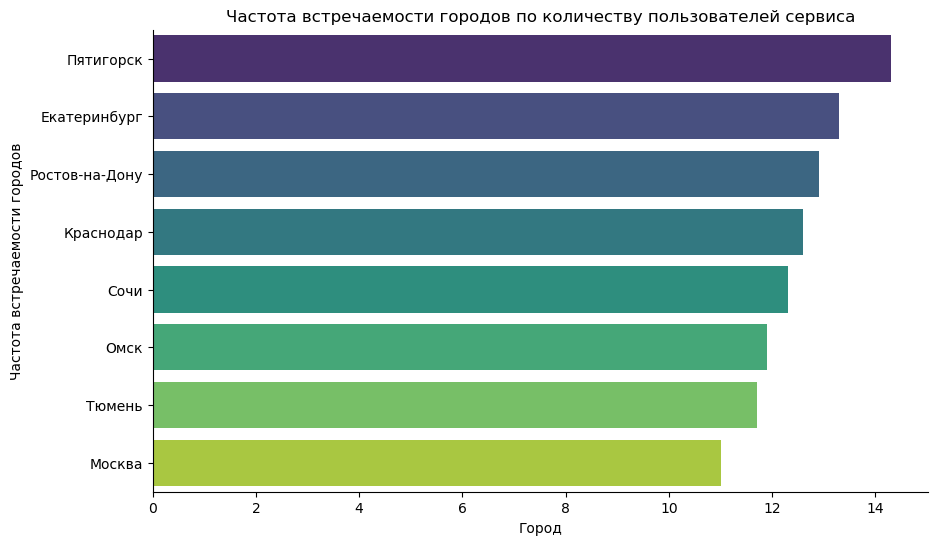

In [34]:
# Построим визуализацию частоты встречаемости городов в датасете users
plt.figure(figsize=(10, 6)) 

# Строим график
sns.barplot(data=city_frequency, y='city', x='%_from_total', palette='viridis')

plt.xlabel('Город')
plt.ylabel('Частота встречаемости городов')
plt.title('Частота встречаемости городов по количеству пользователей сервиса')
plt.grid(False)
sns.despine()

plt.show()

Чаще всего люди пользовались сервисом в Пятигорске, реже всего в Москве. Думаю, что тут  дело в сезонности и погоднях условиях. Скорее всего, прокат самокатов в Москве более востребован в летнее время, в Пятигорске, возможно, зависимость от сезона меньше. После объединения датасетов можно будет проверить эту гипотезу. Также можно нельзя исключать вероятность того, что сервис проката самокатов больше ориентирован на регионы и в Москве не так часто встречается из-за высокой конкуренции. К сожалению, данных о количестве самокатов по городам у нас нет, поэтому проверить эту гипотезу мы не сможем.

In [35]:
# Найдем соотношение пользователй с подпиской и без подписки
sub_type = users.groupby(['subscription_type']).agg({'user_id':'nunique'}).sort_values(by='user_id', 
                                                                           ascending=False).reset_index()
sub_type.columns = ['subscription_type', 'sub_type_cnt']
sub_type['%_from_total'] = round(((sub_type['sub_type_cnt'] / sub_type['sub_type_cnt'].sum()) * 100),1)
sub_type

,subscription_type,sub_type_cnt,%_from_total
0,free,835,54.4
1,ultra,699,45.6


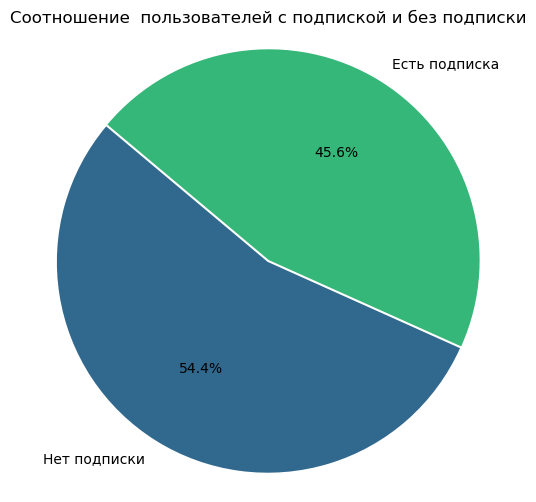

In [36]:
# Построим круговую диаграмму, показывающую соотношение пользователей с подпиской и без подписки в датасете users

plt.figure(figsize=(6, 6))

# Задаем данные для графика
labels = ['Нет подписки', 'Есть подписка']
sizes = [sub_type['%_from_total'][0], sub_type['%_from_total'][1]]
colors = sns.color_palette('viridis', len(labels))

# Строим график
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode = (0.01, 0))

plt.title('Соотношение  пользователей с подпиской и без подписки')
plt.axis('equal')

plt.show()

Пользователей сервиса без подписки больше на 8.8%, чем пользователей с подпиской. У сервиса есть хорошая база постоянных клиентов.

In [37]:
# Проверим, люди какого возраста чаще всего пользовались сервисом проката самокатов
age_frequency = users.groupby(['age']).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).\
                       reset_index()
age_frequency.columns = ['age', 'age_cnt']
age_frequency['%_from_total'] = round(((age_frequency['age_cnt'] / age_frequency['age_cnt'].sum()) * 100),1)
age_frequency

,age,age_cnt,%_from_total
0,25,145,9.5
1,24,132,8.6
2,26,131,8.5
3,23,129,8.4
4,27,119,7.8
5,22,119,7.8
6,28,112,7.3
7,21,93,6.1
8,20,71,4.6
9,30,68,4.4


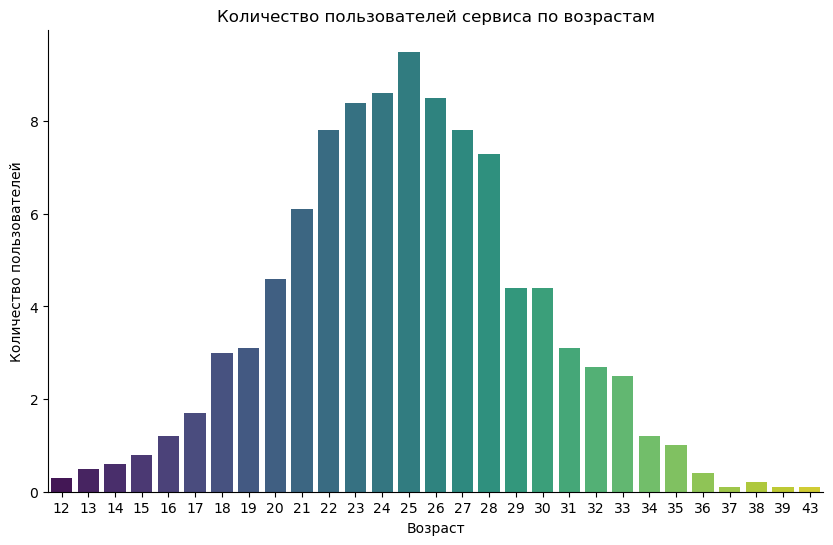

In [38]:
# Построим визуализацию количества пользователей сервиса по возрастам
plt.figure(figsize=(10, 6)) 

# Строим график
sns.barplot(data=age_frequency, x='age', y='%_from_total', palette='viridis')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по возрастам')
plt.grid(False)
sns.despine()

plt.show()

Основная масса пользователей по возрасту попадает в интервал 22-38 лет. Больше всего 25-летних пользователей, как я и писала в начале исследования.

In [39]:
# Проанализируем расстрояние, которое пользователь преодолел за поездку
display(rides['distance'].describe())

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Расстояние нам дано в метрах, значит минимальное расстояние равно примерно 85 см, среднее около 3 км, максимальное - 7.2 км, стандартное отклонение довольно большое, примерно 1.1 км, явно есть выбросы.

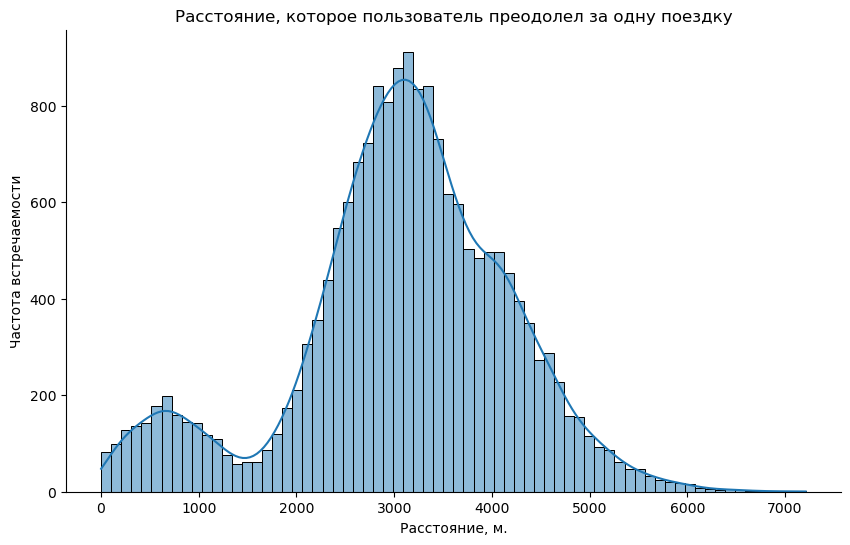

In [40]:
# Визуализируем данные по расстоянию за одну поездку
plt.figure(figsize=(10, 6)) 

# Строим график
sns.histplot(data=rides['distance'], kde=True, bins=70)
plt.xlabel('Расстояние, м.')
plt.ylabel('Частота встречаемости')
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.grid(False)
sns.despine()

plt.show()

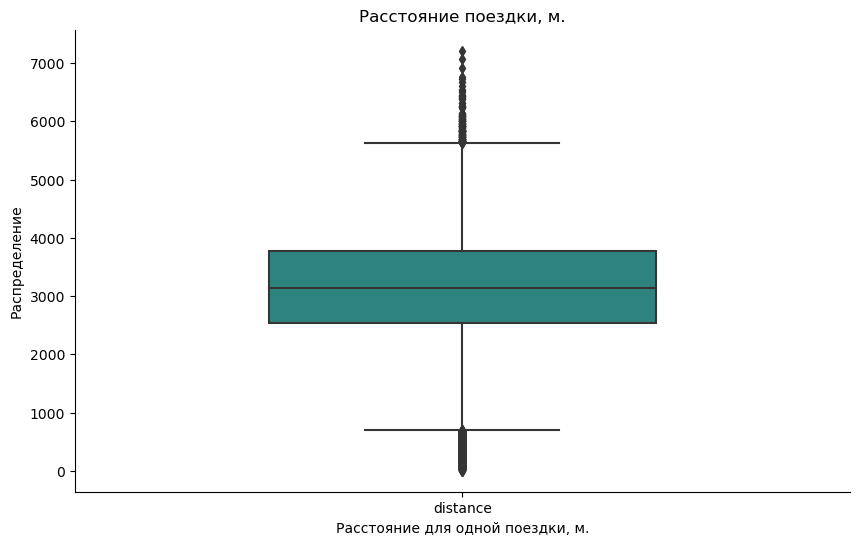

In [41]:
# Построим boxplot для столбца distance
plt.figure(figsize=(10, 6))

sns.boxplot(data=rides[['distance']], palette='viridis', width=0.5)
plt.xlabel('Расстояние для одной поездки, м.')
plt.ylabel('Распределение')
plt.title('Расстояние поездки, м.')
plt.grid(False)
sns.despine()

plt.show()
plt.show()

Мы видим два пика по расстоянию поездки, первый приходится на 600-700 метров. 

Могу предположить, что это может быть связано с двумя причинами. Первая причина: есть пользователи, которые давно хотели потестировать сервис или попробовать покататься на самокатах, они попробовали и им не понравилось, в связи с чем поездка была прервана. Вторая причина: техническая - самокат оказался неисправен, у него разрядился аккамулятор и т.д.

Второй пик приходится на расстояние примерно от 2.5 до 3.8 км. В данном случае, люди скорее всего используют самокаты, чтобы быстро добираться на недальние расстояния до магазинов, школ, работы.

Медиана значений - 3133 м. Также мы видим на гистограмме правый "хвост", с расстоянием больше 5.5 км, похожий на выбросы. Проверим данные на выбросы, посмотрим, сколько людей проехало меньше 600 м и больше 6 км.

In [42]:
print(f'Поездки до 600 м.: {len(rides.query("distance <= 600"))}')
print(f'Поездки больше 6 км.: {len(rides.query("distance >= 6000"))}')

Поездки до 600 м.: 728
Поездки больше 6 км.: 46


Коротких поездок в целом немало, а вот больше 6 км всего 46 на 18068 строк. Я оставлю их как есть, мы не можем исключить просто так любителей покататься на самокатах, к тому же приносящих сервису доход.

In [43]:
# Проанализируем продолжительность поездок
display(rides['duration'].describe())

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Продолжительность поездки нам дана в минутах, значит минимальное поездка составила 30 секунд, средняя - около 18 минут, а максимальная почти 41 минуту, стандартное отклонение большое, примерно 6 минут, явно есть выбросы.

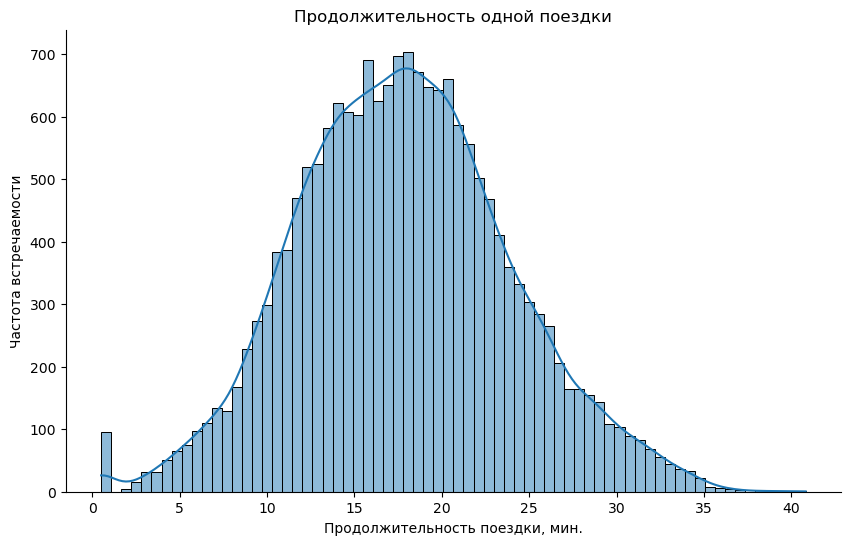

In [44]:
# Визуализируем данные по расстоянию за одну поездку
plt.figure(figsize=(10, 6)) 

# Строим график
sns.histplot(data=rides['duration'], kde=True, bins=70)
plt.xlabel('Продолжительность поездки, мин.')
plt.ylabel('Частота встречаемости')
plt.title('Продолжительность одной поездки')
plt.grid(False)
sns.despine()

plt.show()

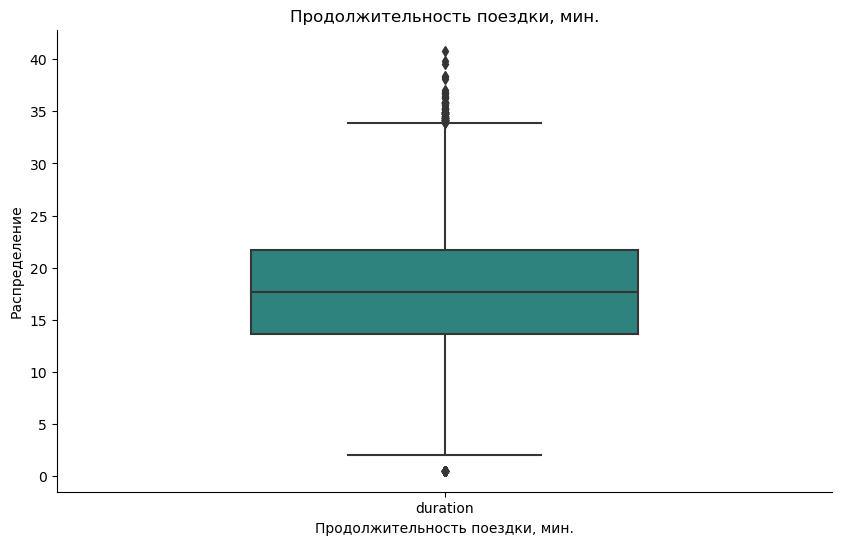

In [45]:
# Построим boxplot для столбца duration
plt.figure(figsize=(10, 6))

sns.boxplot(data=rides[['duration']], palette='viridis', width=0.5)
plt.xlabel('Продолжительность поездки, мин.')
plt.ylabel('Распределение')
plt.title('Продолжительность поездки, мин.')
plt.grid(False)
sns.despine()

plt.show()
plt.show()

Пик длительности поездки приходится на интервал примерно 13-23 минуты. Имеется правый "хвост" после 35 минут, а так же непонятный выброс в интервале до 1 минуты. Посмотрим поближе на данные с прололжительностью поездки меньше 1 минуты, с минимальной продолжительностью поездки 0.5 минут и больше 35.

In [46]:
print(f'Поездки более 35 мин.: {len(rides.query("duration > 35"))}')

Поездки более 35 мин.: 28


In [47]:
rides.query('duration < 1 & duration == 0.5')

,user_id,distance,duration,date,month,season
6531,701,4196.445201,0.5,2021-08-31,8,лето
6570,704,4830.824371,0.5,2021-10-14,10,осень
6680,712,4684.004397,0.5,2021-03-04,3,весна
6695,713,5215.642710,0.5,2021-02-25,2,зима
6768,718,5197.436649,0.5,2021-02-11,2,зима
...,...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1,зима
17242,1477,6724.932981,0.5,2021-01-12,1,зима
17314,1483,4445.481070,0.5,2021-03-06,3,весна
17505,1496,5722.551787,0.5,2021-02-14,2,зима


С поездками больше 35 минут ничего не буду делать, часть из них скорее всего совпадет с теми, кто ездит на длинные расстояния с допустимой скоростью. 95 поездок длительностью меньше минуты вызывают вопросы. Это количество совпадает с минимальными поездками  по времени в 0.5 минуты. Люди начали поездку, потом передумали? Или оплата была отклонена по каким-то причинам? Или еще какая-то техническая причина, например, отсутствие связи самоката с системой ГЛОНАСС, которая отслеживает его местонахождение. Не зная причину, сложно решить, что делать с такими выбросами, потому что, если отказ от поездки произошел по воле пользователя и у него нет подписки, то он оплатил за старт, и мы не можем эти данные просто так исключить. Оставим как есть.

**Выводы:**

На данном этапе мы:
- выяснили, в каких городах люди пользуются сервисом чаще всего: Пятигорск на первом месте, на последнем месте -  Москва;
- проверили соотношение пользователей с подпиской (45.6%) и без подписки (54.4%);
- изучили возраст пользователей сервиса, наиболее активные находятся в интервале 20-30 лет;
- изучили расстояние, которое ппользователи преодолевали за одну поездку, среднее расстояние примерно 3 км;
- изучили продолжительность поездок. Средняя продолжительность поездки составляет примерно 18 минут.

<a id="4"></a>

### Объединение данных

In [48]:
# Выведем краткую информацию по количеству строк и столбцов в датасетах users и rides.
print('Количество строк и столбцов в таблице "users": ', users.shape)
print('Количество строк и столбцов в таблице "rides": ', rides.shape)
print('Количество строк и столбцов в таблице "subscriptions": ', subscriptions.shape)

Количество строк и столбцов в таблице "users":  (1534, 5)
Количество строк и столбцов в таблице "rides":  (18068, 6)
Количество строк и столбцов в таблице "subscriptions":  (2, 4)


In [49]:
# Объединим датасеты  rides и users
data = rides.merge(users, on='user_id', how='left')

In [50]:
# Проведем проверку количества строк и столбцов в объединенном датасете data.
print('Количество строк и столбцов в таблице "data": ', data.shape)

Количество строк и столбцов в таблице "data":  (18068, 10)


In [51]:
# Объединим датасеты  data  и subscriptions
data = data.merge(subscriptions, on='subscription_type', how='left')
data

,user_id,distance,duration,date,month,season,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,зима,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,зима,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,весна,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,лето,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,лето,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,осень,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,осень,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,осень,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,осень,Альберт,25,Краснодар,free,8,50,0


In [52]:
# Проведем проверку количества строк и столбцов в объединенном датасете data
print('Количество строк и столбцов в таблице "data": ', data.shape)

Количество строк и столбцов в таблице "data":  (18068, 13)


Объединение датасетов произошло корректно, мы получили 18068 строк (максимальное количество по датасету rides) и 13 столбцов (всего во всех датасетах 15 столбцов - 2 общих, соответственно).

In [53]:
# Создадим датасет с данными о пользователях сервиса без подписки
data_without_sub = data.query('subscription_type == "free"')

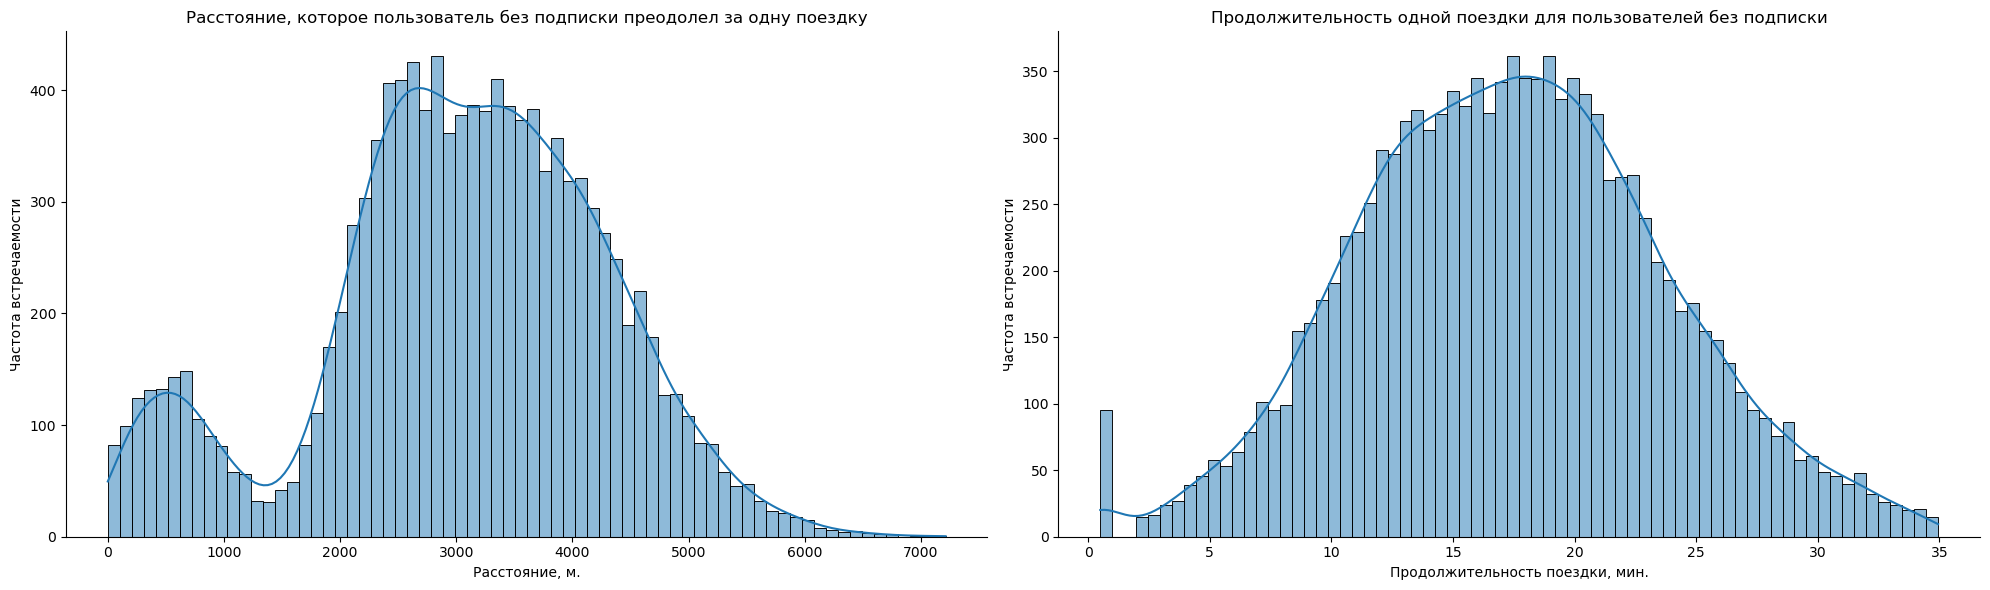

In [54]:
# Визуализируем данные по расстоянию за одну поездку и продолжительность поездки для пользователей без подписки
plt.figure(figsize=(20, 6)) 

# Строим графики
sns.histplot(data=data_without_sub['distance'], kde=True, bins=70, ax=plt.subplot(1,2,1))
plt.xlabel('Расстояние, м.')
plt.ylabel('Частота встречаемости')
plt.title('Расстояние, которое пользователь без подписки преодолел за одну поездку')
plt.grid(False)
sns.despine()

sns.histplot(data=data_without_sub['duration'], kde=True, bins=70, ax=plt.subplot(1,2,2))
plt.xlabel('Продолжительность поездки, мин.')
plt.ylabel('Частота встречаемости')
plt.title('Продолжительность одной поездки для пользователей без подписки')
plt.grid(False)
sns.despine()

plt.tight_layout()
plt.show()

Видим, что графики немного сместились влево по сравнению с целым датасетом. Второй пик по расстоянию начинается примерно с 2.2 км, а заканчивается в районе 4.5, а продолжительность поездки существенно возрастает после 8 минут поездки.

In [55]:
# Создадим датасет данными о пользователях сервиса с подпиской
data_with_sub = data.query('subscription_type == "ultra"')

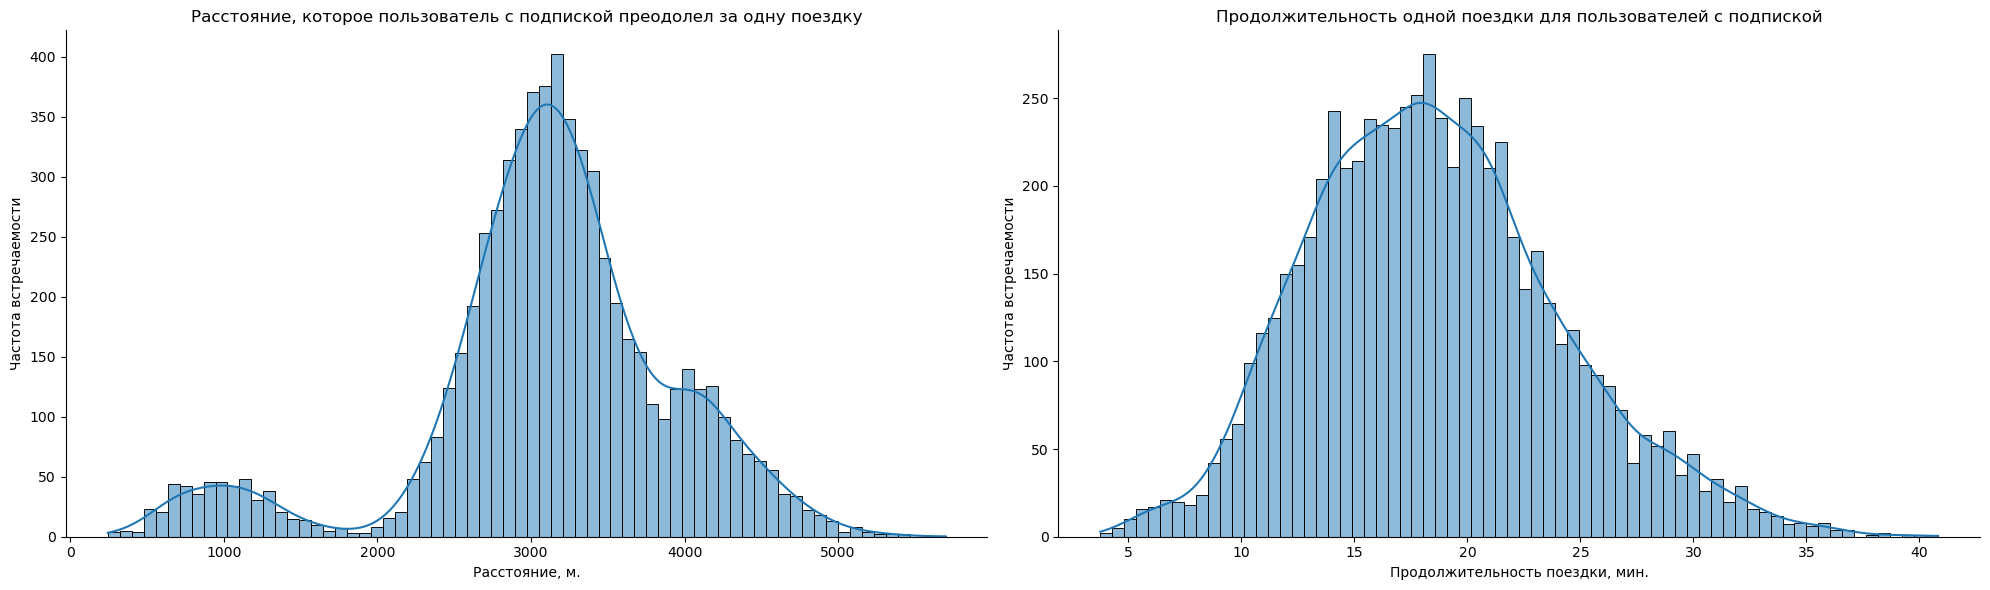

In [56]:
# Визуализируем данные по расстоянию за одну поездку и продолжительность поездки для пользователей с подпиской
plt.figure(figsize=(20, 6)) 

# Строим графики
sns.histplot(data=data_with_sub['distance'], kde=True, bins=70, ax=plt.subplot(1,2,1))
plt.xlabel('Расстояние, м.')
plt.ylabel('Частота встречаемости')
plt.title('Расстояние, которое пользователь с подпиской преодолел за одну поездку')
plt.grid(False)
sns.despine()

sns.histplot(data=data_with_sub['duration'], kde=True, bins=70, ax=plt.subplot(1,2,2))
plt.xlabel('Продолжительность поездки, мин.')
plt.ylabel('Частота встречаемости')
plt.title('Продолжительность одной поездки для пользователей с подпиской')
plt.grid(False)
sns.despine()

plt.tight_layout()
plt.show()

Среди пользователей с подпиской расстояние поездки резко возрастает, начиная с 2 км и второй небольшой пик -  после 4 км, а продолжительность также возрастает примерно после 8 мин.

В целом, у пользователей без подписки значительно больше коротких поездок - до 1 км, и  максимальная дальность поездки выше, чем у платных пользователей.

**Выводы:**

На данном этапе мы:
- объединили три датасета в один - data;
- создали датасеты data_without_sub для пользователй без подписки и data_with_sub для пользователей с подпиской;
- визуализировали данные по расстоянию и длительности поездок по этим датасетам.

<a id="5"></a>

### Подсчёт выручки

In [57]:
# Проверим пропуски в сводном датасете data
data.isna().sum().sort_values()

user_id              0
distance             0
duration             0
date                 0
month                0
season               0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков нет.

In [58]:
# Округлим продолжительность каждой поездки методом np.ceil()
data['duration'] = np.ceil(data['duration']).astype('int64')

In [59]:
# Посчитаем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц
data_agg = data.groupby(['user_id', 'month', 'subscription_type']). \
                agg({'distance':'sum', 'duration':'sum', 'user_id':'count'})
data_agg.columns = ['distance', 'duration', 'rides_per_month']
data_agg = data_agg.reset_index()
data_agg

,user_id,month,subscription_type,distance,duration,rides_per_month
0,1,1,ultra,7027.511294,42,2
1,1,4,ultra,754.159807,7,1
2,1,8,ultra,6723.470560,46,2
3,1,10,ultra,5809.911100,32,2
4,1,11,ultra,7003.499363,56,3
...,...,...,...,...,...,...
11326,1534,6,free,3409.468534,26,2
11327,1534,8,free,7622.453034,48,2
11328,1534,9,free,4928.173852,23,1
11329,1534,11,free,13350.015305,78,4


In [60]:
# Добавим столбец с помесячной выручкой, которую принес каждый пользователь
data_agg['revenue_per_month'] = data['start_ride_price'] * data_agg['rides_per_month'] + \
                                data['minute_price'] * data_agg['duration'] + data['subscription_fee']
data_agg   

,user_id,month,subscription_type,distance,duration,rides_per_month,revenue_per_month
0,1,1,ultra,7027.511294,42,2,451.0
1,1,4,ultra,754.159807,7,1,241.0
2,1,8,ultra,6723.470560,46,2,475.0
3,1,10,ultra,5809.911100,32,2,391.0
4,1,11,ultra,7003.499363,56,3,535.0
...,...,...,...,...,...,...,...
11326,1534,6,free,3409.468534,26,2,308.0
11327,1534,8,free,7622.453034,48,2,484.0
11328,1534,9,free,4928.173852,23,1,234.0
11329,1534,11,free,13350.015305,78,4,824.0


**Выводы:**

На данном этапе мы:
- проверили пропуски в сводном датасете data;
- округлили значения в столбце duration датасета data до целого по методу "потолок";
- создали датасет data_agg с агрегированными данными о поездах на основе датасета data:
  - нашли суммарное расстояние в месяц для каждого пользователя;
  - количество поездок в  месяц для каждого пользователя;
  - суммарное время поездки в месяц для каждого пользователя;
- добавили столбец revenue_per_month c помесячной выручкой, которую принес каждый пользователь.

<a id="6"></a>

###  Дополнительный исследовательский анализ данных

Посмотрим интереса ради, как пользователи с подпиской и без распределились по городам, возрастам, расстоянию поездки и проанализируем, влияет ли сезонность на активность пользователей сервиса.

In [61]:
# Посчитаем пользователей с подпиской по городам
city_with_sub = data_with_sub.groupby(['city']).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).\
                       reset_index()
city_with_sub.columns = ['city', 'city_cnt']
city_with_sub['%_from_total'] = round(((city_with_sub['city_cnt'] / city_with_sub['city_cnt'].sum()) * 100),1)
city_with_sub

,city,city_cnt,%_from_total
0,Пятигорск,94,13.4
1,Екатеринбург,92,13.2
2,Омск,91,13.0
3,Ростов-на-Дону,89,12.7
4,Сочи,86,12.3
5,Москва,84,12.0
6,Тюмень,82,11.7
7,Краснодар,81,11.6


In [62]:
# Посчитаем пользователей без подписки по городам
city_without_sub = data_without_sub.groupby(['city']).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).\
                       reset_index()
city_without_sub.columns = ['city', 'city_cnt']
city_without_sub['%_from_total'] = round(((city_without_sub['city_cnt'] / city_without_sub['city_cnt'].sum()) * 100),1)
city_without_sub

,city,city_cnt,%_from_total
0,Пятигорск,125,15.0
1,Екатеринбург,112,13.4
2,Краснодар,112,13.4
3,Ростов-на-Дону,109,13.1
4,Сочи,103,12.3
5,Тюмень,98,11.7
6,Омск,92,11.0
7,Москва,84,10.1


In [63]:
# Объединим данные
city_sub_merge = city_with_sub[['city', '%_from_total']].\
                merge(city_without_sub[['city', '%_from_total']], on='city', how='left')

city_sub_merge.columns = ['city', 'with_sub', 'without_sub']

city_sub_merge       

,city,with_sub,without_sub
0,Пятигорск,13.4,15.0
1,Екатеринбург,13.2,13.4
2,Омск,13.0,11.0
3,Ростов-на-Дону,12.7,13.1
4,Сочи,12.3,12.3
5,Москва,12.0,10.1
6,Тюмень,11.7,11.7
7,Краснодар,11.6,13.4


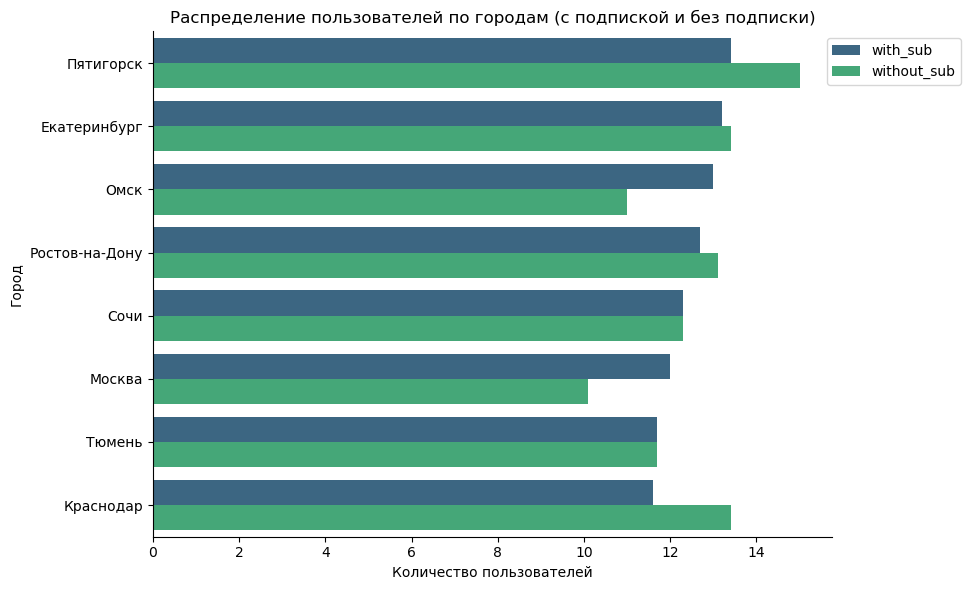

In [64]:
# Построим визуализацию распределения пользователей с подпиской и без подписки по городам
city_sub_merge_sorted = city_sub_merge.sort_values(by='with_sub', ascending=False)

melted_data = pd.melt(city_sub_merge_sorted, id_vars='city', value_vars=['with_sub', 'without_sub'],
                      var_name='Наличие подписки', value_name='Количество пользователей')

plt.figure(figsize=(10, 6))

# Cтроим график
sns.barplot(x='Количество пользователей', y='city', hue='Наличие подписки', data=melted_data, orient='h', 
            palette='viridis')

plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.title('Распределение пользователей по городам (с подпиской и без подписки)')
sns.despine()
plt.grid(False)
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.tight_layout()

plt.show()

На графике мы видим, что в Пятигорске, Краснодаре, Ростове-на-Дону больше пользователей без подписки, вероятно, больше случайных пользователей (шел, увидел самокал, решил прокатиться). В Москве и Омске, наоборот, пользователй с подпиской, постоянно пользующихся сервисом больше, чем без подписки.

In [65]:
# Посчитаем пользователей с подпиской по возрастам
age_with_sub = data_with_sub.groupby(['age']).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).\
                       reset_index()
age_with_sub.columns = ['age', 'age_cnt']
age_with_sub['%_from_total'] = round(((age_with_sub['age_cnt'] / age_with_sub['age_cnt'].sum()) * 100),1)
age_with_sub

,age,age_cnt,%_from_total
0,24,64,9.2
1,23,62,8.9
2,25,60,8.6
3,27,54,7.7
4,26,53,7.6
5,22,47,6.7
6,28,42,6.0
7,29,35,5.0
8,20,34,4.9
9,21,34,4.9


In [66]:
# Посчитаем пользователей без подписки по возрастам
age_without_sub = data_without_sub.groupby(['age']).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).\
                       reset_index()
age_without_sub.columns = ['age', 'age_cnt']
age_without_sub['%_from_total'] = round(((age_without_sub['age_cnt'] / age_without_sub['age_cnt'].sum()) * 100),1)
age_without_sub

,age,age_cnt,%_from_total
0,25,85,10.2
1,26,78,9.3
2,22,72,8.6
3,28,70,8.4
4,24,68,8.1
5,23,67,8.0
6,27,65,7.8
7,21,59,7.1
8,30,39,4.7
9,20,37,4.4


In [67]:
# Объединим данные и возьмем для анализа топ-10 возрастов
age_sub_merge = age_with_sub[['age', '%_from_total']].\
                merge(age_without_sub[['age', '%_from_total']], on='age', how='left')

age_sub_merge.columns = ['age', 'with_sub', 'without_sub']

age_sub_merge = age_sub_merge.head(10)  
age_sub_merge

,age,with_sub,without_sub
0,24,9.2,8.1
1,23,8.9,8.0
2,25,8.6,10.2
3,27,7.7,7.8
4,26,7.6,9.3
5,22,6.7,8.6
6,28,6.0,8.4
7,29,5.0,4.0
8,20,4.9,4.4
9,21,4.9,7.1


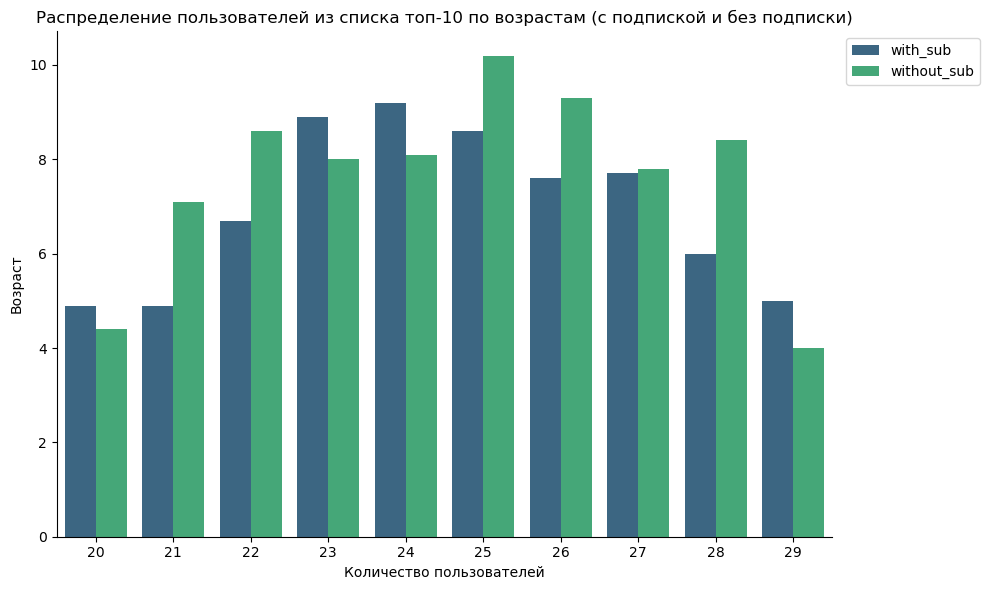

In [68]:
# Построим визуализацию распределения пользователей с подпиской и без подписки по возрастам

melted_data1 = pd.melt(age_sub_merge, id_vars='age', value_vars=['with_sub', 'without_sub'],
                      var_name='Наличие подписки', value_name='Количество пользователей')

plt.figure(figsize=(10, 6))

# Cтроим график
sns.barplot(y='Количество пользователей', x='age', hue='Наличие подписки', data=melted_data1, 
            palette='viridis')

plt.xlabel('Количество пользователей')
plt.ylabel('Возраст')
plt.title('Распределение пользователей из списка топ-10 по возрастам (с подпиской и без подписки)')
sns.despine()
plt.grid(False)
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.tight_layout()

plt.show()

В топ-10 нашего списка попали люди в возрасте от 20 до 29 лет, как ни странно. И купили подписку только 20, 23, 24, 29-летние. Количество людей в возрасте 21,22,25,26,28 лет без подписки существенно превышает тех, кто с подпиской. Честно говоря, сложно даже предположить, почему так. Вероятно, от возраста наличие подписки не особо зависит, а зависит больше от необходимости передвижения на самокате и финансовой возможности.

In [69]:
# Посчитаем среднее расстояние для пользователeй с подпиской и без подписки
print(f'Среднее расстояние поездки (с подпиской): {round(data_with_sub["distance"].mean(),1)}')
print(f'Среднее расстояние поездки (без подписки): {round(data_without_sub["distance"].mean(),1)}')

Среднее расстояние поездки (с подпиской): 3115.4
Среднее расстояние поездки (без подписки): 3045.5


Пользователи с подпиской в среднем проезжают большее расстояние, чем без подписки.

In [70]:
# Изучим, как влияет сезонность на активность пользователей в целом по городам
season_city = data.groupby(['city', 'season']).agg({'user_id':'nunique'}).sort_values(by=['city', 'season'])
season_city

user_id
city           season         
Екатеринбург   весна       194
               зима        192
               лето        192
               осень       190
Краснодар      весна       182
               зима        178
               лето        185
               осень       180
Москва         весна       157
               зима        155
               лето        158
               осень       154
Омск           весна       177
               зима        170
               лето        170
               осень       164
Пятигорск      весна       205
               зима        199
               лето        209
               осень       204
Ростов-на-Дону весна       187
               зима        190
               лето        188
               осень       183
Сочи           весна       179
               зима        178
               лето        176
               осень       173
Тюмень         весна       168
               зима        166
               лето        172
               осень       168

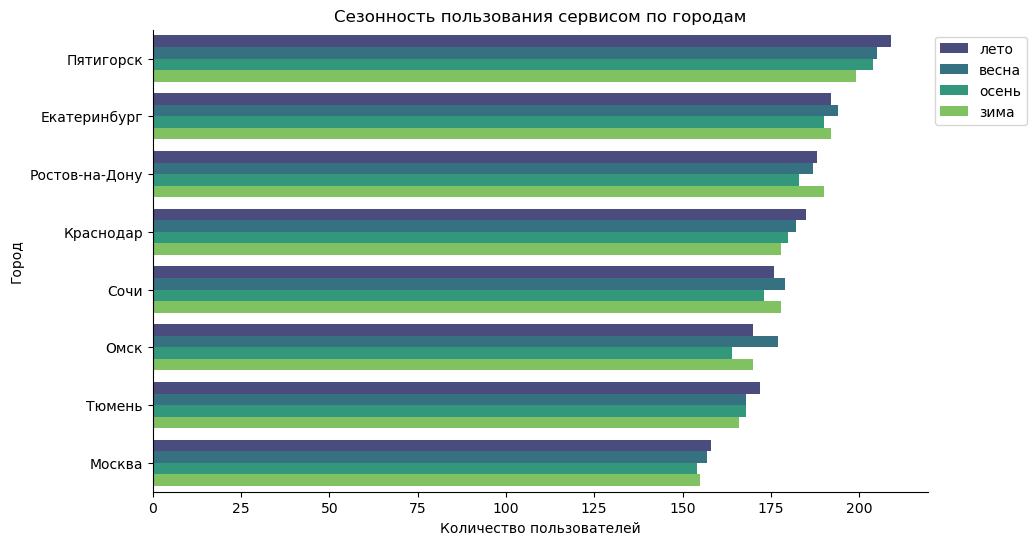

In [71]:
# Построим визуализацию 
season_city = season_city.sort_values(by='user_id', ascending=False).reset_index()

plt.figure(figsize=(10, 6))

sns.barplot(data = season_city,  y = 'city', x = 'user_id', palette = 'viridis', hue = 'season')
plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.title('Сезонность пользования сервисом по городам')
sns.despine()
plt.grid(False)
plt.legend(bbox_to_anchor=(1.0, 1.0))

plt.show()

Сезонность, конечно, присутствует, но, похоже, в каждом городе своя. С учетом географического разброса городов, в этом есть свой смысл. Что интересно, в некоторых городах весной и зимой спрос на сервис выше, вероятно, из-за холодной погоды люди быстрее хотят добраться до нужного места и используют самокаты, а в некоторых, наоборот, вероятно, также по причине погоды, но на этот раз  жаркой.

**Выводы:**

На данном этапе мы:
- проанализировали, как пользователи с подпиской и без нее рапределены по городам: в Пятигорске, Краснодаре, Ростове-на-Дону больше пользователей без подписки, вероятно, больше случайных пользователей, а в Москве и Омске, наоборот, пользователей с подпиской, постоянно пользующихся сервисом больше, чем без подписки;
- как пользователи с подпиской и без нее распределены по возрасту. В топ-10 возрастов среди всех пользователей сервиса попали люди в возрасте от 20 до 29 лет. Скорее всего, от возраста наличие подписки не особо зависит, а зависит больше от необходимости передвижения на самокате и финансовой возможности;
- нашли среднее растояние поездки для пользователей с подпиской (3115.4 м) и без нее (3045.5 м);
- изучили сезонность использования сервиса. С учетом географического разброса городов сезонность присутствует, возможно, люди пользуются самокатами в холодную и жаркую погоду, чтобы быстрее добраться до места, или просто приятно в хорошую погоду покататься на самокате по городу.  

<a id="7"></a>

###  Проверка гипотез

#### Первая гипотеза:
*Тратят ли пользователи с подпиской больше времени на поездки?*

Нулевая гипотеза (H0): пользователи с подпиской тратят на поездки столько же времени, сколько пользователи без подписки.

Альтернативная гипотеза (H1): пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

In [72]:
# Проверим данную гипотезу, используем метод st.ttest_ind, так как у нас группы пользователей разные, то 
# дисперсия может быть разная, поэтому зададим параметр equal_var=False

alpha = 0.05 # уровень статистической значимости, если p-value окажется меньше него, то отвергнем гипотезу

results1 = st.ttest_ind(data_with_sub['duration'], data_without_sub['duration'], equal_var=False, 
                        alternative='greater')
print(f'pvalue: {results1.pvalue}')

if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

pvalue: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


С помощью статистического теста мы отвергли нулевую гипотезу, так как P-value=5.68*10^(-37), что ничтожно мало, гораздо ниже уровня статистической значимости. Мы можем подтвердить альтернативную гипотезу, что пользователи с подпиской тратят больше времени  на поездки, чем бользователи без подписки.

In [73]:
# Посчитаем сколько в среднем времени тратят пользователи с подпиской на поездку и пользователи без подписки,
# а также насколько минут это среднее время отличается
display(f'Среднее время поездки (с подпиской): {round(data_with_sub["duration"].mean(), 2)}')
display(f'Среднее время поездки (без подписки): {round(data_without_sub["duration"].mean(), 2)}')
display(f'Разница: {round(data_with_sub["duration"].mean() - data_without_sub["duration"].mean(), 2)}')

'Среднее время поездки (с подпиской): 18.54'

'Среднее время поездки (без подписки): 17.39'

'Разница: 1.15'

Пользователи с подпиской в среднем тратят на 1.2 минут больше на поездку, чем пользователи без подписки.

#### Вторая гипотеза:

*Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м? Такое расстояние является оптимальным с точки зрения износа самоката.*

Нулевая гипотеза (H0): пользователи с подпиской проезжают за одну поездку расстояние, не превышающее 3130 м.

Альтернативная гипотеза (H1): пользователи с подпиской проезжают за одну поездку расстояние, которое превышает 3130 м.

In [74]:
# Проверим данную гипотезу, используем метод st.ttest_1samp

interested_value = 3130

alpha = 0.05 # уровень статистической значимости, если p-value окажется меньше него, то отвергнем гипотезу

results2 = st.ttest_1samp(data_with_sub['distance'], interested_value, alternative = 'greater')
print(f'pvalue: {results2.pvalue}')

if results2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

pvalue: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


С помощью статистического теста мы отвергнуть нулевую гипотезу не можем, так как P-value составлет около 91%. Значит пользователи с подпиской за одну поездку проезжают расстояние, не превышающее 3130 м.

In [75]:
# Посчитаем, какое в среднем расстояние проезжают пользователи с подпиской
display(f'Среднее расстояние поездки (с подпиской): {round(data_with_sub["distance"].mean(), 1)}')

'Среднее расстояние поездки (с подпиской): 3115.4'

Пользователи с подпиской в среднем проезжают 3115.4 м за поездку, что действительно не превышает 3130 метров, хоть и разница не очень большая. 

#### Третья гипотеза:

*Будет ли помесячная  выручка от пользователей с подпиской по месяцам выше, чем помесячная выручка пользователей без подписки?*

Нулевая гипотеза (H0): помесячная выручка от пользователей с подпиской равна помесячной выручке от пользователей без подписки.

Альтернативная гипотеза (H1): помесячная выручка от пользователей с подпиской выше, чем помесячная выручка от пользователей без подписки.

In [76]:
# Проверим гипотезу, используем метод st.ttest_ind, так как у нас группы пользователей разные, то 
# дисперсия может быть разная, поэтому зададим параметр equal_var=False

alpha = 0.05 # уровень статистической значимости, если p-value окажется меньше него, то отвергнем гипотезу

results3 = st.ttest_ind(data_agg.query('subscription_type == "ultra"')['revenue_per_month'], 
                        data_agg.query('subscription_type == "free"')['revenue_per_month'], 
                        equal_var=False, alternative='greater')
print(f'pvalue: {results3.pvalue}')

if results3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

pvalue: 3.522420352703165e-15
Отвергаем нулевую гипотезу


С помощью статистического теста мы отвергаем нулевую гипотезу, так как P-value=1.19*10^(-17), что ничтожно мало. Мы можем подтвердить альтернативную гипотезу, что помесячная выручка от пользователей с подпиской выше, чем помесячная выручка от пользователей без подписки.

In [77]:
# Посчитаем среднюю выручку пользователей с подпиской и пользователей без подписки, а также насколько рублей
# эти средние  выручки отличаются
print('Средняя выручка (с подпиской):',
      round(data_agg.query('subscription_type == "ultra"')['revenue_per_month'].mean(), 2))
print('Среднее выручка (без подписки):', 
      round(data_agg.query('subscription_type == "free"')['revenue_per_month'].mean(), 2))
print('Разница:', round(data_agg.query('subscription_type == "ultra"')['revenue_per_month'].mean() - \
                  data_agg.query('subscription_type == "free"')['revenue_per_month'].mean(), 2))

Средняя выручка (с подпиской): 362.79
Среднее выручка (без подписки): 343.94
Разница: 18.85


Cредняя выручка от пользователей с подпиской в среднем на  20.1 рубль выше, чем от пользователей без подписки.

#### Теоретический вопрос:

*Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Какой тест мы можем использовать, чтобы понять снизилось ли количество обращений в техподдержку после обновления серверов, на основании файла, содержащего данные о количестве обращений каждого пользователя до обновления и после него?*

Для проверки данной гипотезы о равенстве средних для зависимых (парных) выборок мы можем использовать метод scypy.stats.ttest_rel(), передав ему в качестве параметров две выборки с одними и теми же пользователями до обновления и после.

**Выводы:**

На данном этапе мы:
- проверили 3 гипотезы:
  - *Тратят ли пользователи с подпиской больше времени на поездки?* Гипотеза подтвердилась. Пользователи с подпиской тратят на 1.15 минуты времени на поездку больше, чем пользователи без подписки;
  - *Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м?* Гипотеза подтвердилась. Пользователи с подпиской в среднем проезжают 3115.4 м за поездку;
  - *Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем помесячная выручка пользователей без подписки?* Гипотеза подтвердилась. Cредняя выручка от пользователей с подпиской в среднем на 20.1 рубль выше, чем от пользователей без подписки.
- ответили на теоретический вопрос. Для проверки гипотезы о равенстве средних для зависимых (парных) выборок мы можем использовать метод scypy.stats.ttest_rel().

<a id="8"></a>

###  Распределения

#### Задание 1

Отделу маркетинга сервиса нужно провести акцию с раздачей  промокодов на один бесплатный месяц подписки, в рамках которой минимум 100 существующих клиентов должны продлить эту подписку. По опыту прошлой акции подписку продлили 10% пользователей.

*Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%.

Возьмем интервал предположительных значений n от 100 (наше целевое значение пользователей, чтобы получить 100 продлений вряд ли можно разослать меньше 100 промокодов) до, например, 2000. 

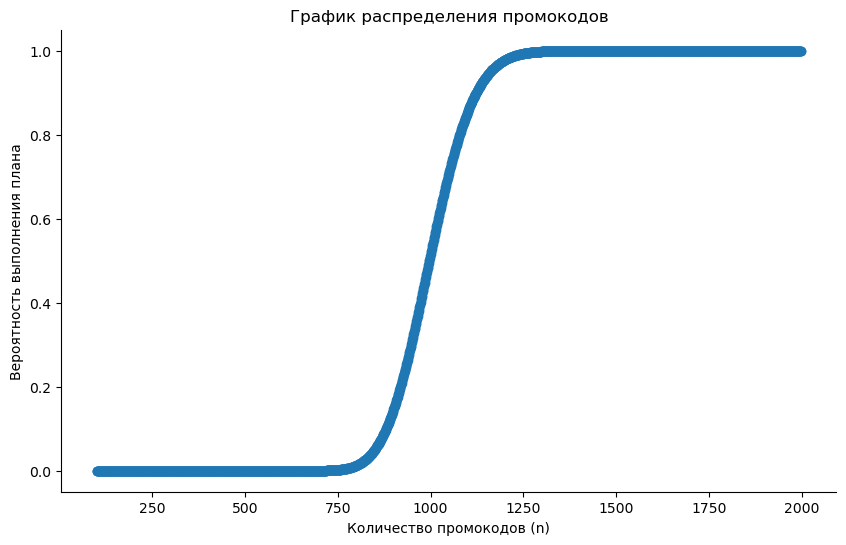

In [78]:
p = 0.1  # вероятность успеха (подписка продлена)
customers = 100  # минимальное количество успешных подписок для достижения цели
p1 = 0.05  # вероятность невыполнения плана

# Создаем массив предположительных значений n для построения графика
n = np.arange(100, 2000)

# Вычисляем вероятности для каждого значения n
probabilities = [1 - binom.cdf(customers - 1, n, p) for n in n]

# Строим график
plt.figure(figsize=(10, 6))

plt.plot(n, probabilities, marker='o', linestyle='-')
plt.xlabel('Количество промокодов (n)')
plt.ylabel('Вероятность выполнения плана')
plt.title('График распределения промокодов')
plt.grid(False)
sns.despine()

plt.show()

На графике мы видим, что наше число промокодов лежит в интервале 1100-1200.

In [79]:
# Напишем функцию для поиска числа промокодов
def min_n(p, customers, p1):
    n = 1  # начинаем с 1 промокода
    while binom.cdf(customers - 1, n, p) > p1:
        n += 1
    return n

# Вычисляем минимальное количество промокодов
min_n = min_n(p, customers, p1)

print(f'Минимальное количество промокодов: {min_n}')

Минимальное количество промокодов: 1161


Проверим это значение.

In [80]:
# Задаём параметры биномиального распределения
n = 1161 # количество испытаний
p = 0.95 # вероятность выполнить план (1-0.05)

# Задаём параметры нормального распределения равными мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# Задаём нормальное распределение
distr1 = st.norm(mu, sigma) 

result4 = 1 - distr1.cdf(100)

print(result4)

1.0


Итак, при количестве промокодов 1161 вероятность невыполнения плана составляет 5%.

#### Задание 2

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Уведомления открывают  около 40% получивших клиентов. Планируется разослать 1 млн. уведомлений.

*Оцените вероятность того, что уведомление откроют более 399.5 тыс. пользователей.*

In [81]:
# Задаём параметры биномиального распределения
n = 1000000 # количество испытаний
p = 0.4 # вероятность успеха

# Задаём параметры нормального распределения равными мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# Задаём нормальное распределение
distr2 = st.norm(mu, sigma) 

# Считаем вероятность получить значение меньше 399.5 тысяч
result5 = distr2.cdf(399500)

print(result5)

0.15371708296369768


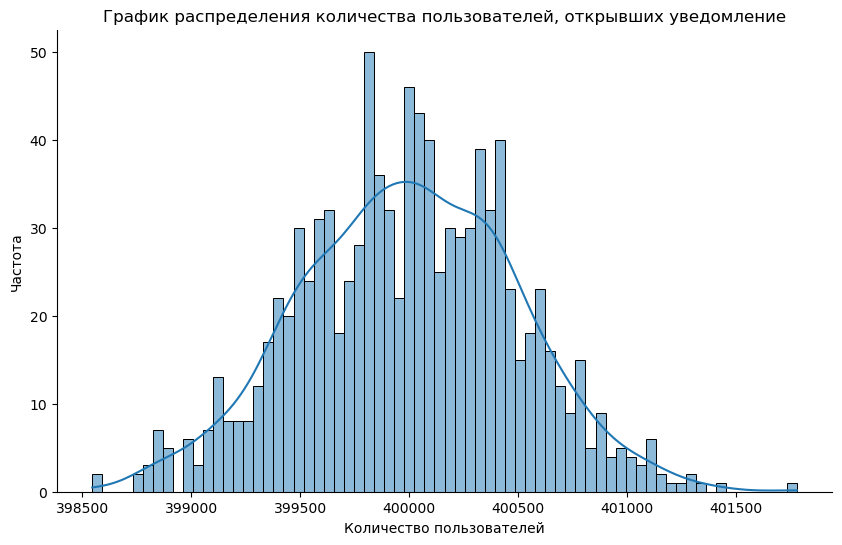

In [82]:
# Построим примерный график распределения
plt.figure(figsize=(10, 6)) 

distr2_plot = np.random.normal(mu, sigma, 1000)

sns.histplot(data=distr2_plot, kde=True, bins=70)

plt.xlabel('Количество пользователей')
plt.ylabel('Частота')
plt.title('График распределения количества пользователей, открывших уведомление')
plt.grid(False)
sns.despine()

plt.show()

Вероятность того, что уведомление откроют не более  399.5 тысяч составляет около 15%.

**Выводы:**

На данном этапе мы:
- нашли минимально еколичество промокодов, при котором вероятность невыполнения планов будет составлять 5%;
- посчитали вероятность того, что менее 399.5 тысяч пользователей откроют уведомление - 15%.

<a id="9"></a>

###  Общий вывод

Мы провели исследование данных сервиса аренды самокатов GoFast в период с 1 января по 30 декабря 2021 года.
***Исследование состояло из следующих этапов:***

- ***Загрузка и базовый анализ данных:***
  - Прочитали файлы с данными;
  - Вывели и изучили общую информацию о них.

  
- ***Предобработка данных:***
  - Преобразовали тип данных в столбце date датасета rides во временной формат;
  - Проверили данные на пропуски - их нет;
  - Проверили данные на дубликаты - их нет, в датасете users найдена 31 строка с явными дубликатами, удалили их;
  - Изучили уникальные значения в датасете users, все данные оставили без изменений;
  - Выяснили, что период анализа у нас с 21-01-01 по 21-12-30;
  - Добавили новые столбцы month и season в датасет rides.

- ***Исследовательский анализ данных:***
  - Выяснили, в каких городах люди пользуются сервисом чаще всего: Пятигорск на первом месте, на последнем месте - Москва;
  - Проверили соотношение пользователей с подпиской (45.6%) и без подписки (54.4%);
  - Изучили возраст пользователей сервиса, наиболее активные находятся в интервале 20-30 лет;
  - Изучили расстояние, которое ппользователи преодолевали за одну поездку, среднее расстояние примерно 3 км;
  - Изучили продолжительность поездок. Средняя продолжительность поездки составляет примерно 18 минут.
 
- ***Объединение данных:***
  - Объединили три датасета в один - data;
  - Создали датасеты data_without_sub для пользователей без подписки и data_with_sub для пользователей с подпиской;
  - Визуализировали данные по расстоянию и длительности поездок по этим датасетам.

- ***Подсчет выручки:***
  - Создали датасет data_agg с агрегированными данными о поездах на основе датасета data:
    - нашли суммарное расстояние в месяц для каждого пользователя;
    - количество поездок в месяц для каждого пользователя;
    - суммарное время поездки в месяц для каждого пользователя.
  - Округлили значения в столбце duration до целого по методу "потолок";
  - Добавили столбец revenue_per_month c помесячной выручкой, которую принес каждый пользователь.
  
- ***Дополнительный исследовательский анализ:***
  - Проанализировали, как пользователи с подпиской и без нее рапределены по городам: в Пятигорске, Краснодаре, Ростове-на-Дону больше пользователей без подписки, вероятно, больше случайных пользователей, а в Москве и Омске, наоборот, пользователй с подпиской, постоянно пользующихся сервисом больше, чем без подписки;
  - Как пользователи с подпиской и без нее распределены по возрасту. В топ-10 возрастов среди всех пользователей сервиса попали люди в возрасте от 20 до 29 лет. Скорее всего, от возраста наличие подписки не особо зависит, а зависит больше от необходимости передвижения на самокате и финансовой возможности;
  - Нашли среднее растояние поездки для пользователей с подпиской (3115.4 м) и без нее (3045.5 м);
  - Изучили сезонность использования сервиса. С учетом географического разброса городов сезонность присутствует, возможно, люди пользуются самокатами в холодную и жаркую погоду, чтобы быстрее добраться до места, или просто приятно в хорошую погоду покататься на самокате по городу.  

- ***Проверка гипотез:***
  - Проверили 3 гипотезы:
    - *Тратят ли пользователи с подпиской больше времени на поездки?* Гипотеза подтвердилась. Пользователи с подпиской тратят на 1.15 минуты времени на поездку больше, чем пользователи без подписки;
    - *Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м?* Гипотеза подтвердилась. Пользователи с подпиской в среднем проезжают 3115.4 м за поездку;
    - *Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем помесячная выручка пользователей без подписки?* Гипотеза подтвердилась. Cредняя выручка от пользователей с подпиской в среднем на 20.1 рубль выше, чем от пользователей без подписки.
  - Ответили на теоретический вопрос. Для проверки гипотезы о равенстве средних для зависимых (парных) выборок мы можем использовать метод scypy.stats.ttest_rel().

- ***Распределения:***
  - Нашли минимально еколичество промокодов, при котором вероятность невыполнения планов будет составлять 5%;
  - Посчитали вероятность того, что менее 399.5 тысяч пользователей откроют уведомление - 15%.

Таким образом, на основании вышеизложенного, можно сделать следующие выводы о причинах убыточности компании за последние несколько месяцев:

***Рекомендации:***

В результате анализа мы выяснили, что в целом пользователи с подпиской приносят большую выручку, чем пользователи без подписки. Отсюда следуют два направления для повышения эффективности бизнеса:
- Удержание текущих пользователей с подпиской:
  - для постоянных клиентов можно ввести систему лояльности, например, проехал 2 часа, получи бесплатно 15 минут;
  - дарить промокоды на скидку на поездки в честь дня рождения;
  - акция "Приведи друга", получи 5 поездок в подарок и т.д. 
- Привлечение новых пользователей, которые оплатят подписку:
  - акция "Первые 15 минут после регистрации в приложении бесплатно", чтобы пользователи могли потестировать сервис;
  - акции, имеющие категориальный характер, например, скидки для школьников и студентов, подарки на день молодежи, так как основная масса пользователей - люди до 30 лет.
- Также я бы рекомендовала обратить внимание на сезонность, но с учетом географического положения города. 